In [49]:
import numpy as np
from pathlib import Path
import table
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
from collections import defaultdict
import keras
from linked_neurons import SeparatingReLU
from keras.models import model_from_json
import dill as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from slugify import slugify
# %load_ext line_profiler

In [4]:
def extract_metrics(event_file):
    results = []
    for e in tf.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag.endswith('loss') or v.tag.endswith('acc'):
                results.append((e.step, e.wall_time, v.tag, v.simple_value))

    return pd.DataFrame(results, columns=['epoch', 'wall time', 'tag', 'value'])

def get_table_grid(path, selected_activations=None):
    architecture_regex = re.compile('-(\d+)x(\d+)-')
    bs_regex = re.compile('-bs-(\d+)-')

    sr_regex = re.compile('-sr-(\d+)(?:-(\d+))?(?:(e-\d+))?-')
    path = Path(path)
    results = defaultdict(lambda: defaultdict(pd.DataFrame)) # tag, activation
    for summary_path in tqdm(path.iterdir(), total=len(list(path.iterdir()))):
        if summary_path.is_dir():
            path = summary_path
#             print(summary_path)
            event_file = list(path.glob('*events*'))            
            if event_file:                    
                event_file = str(event_file[0].resolve())
                depth, width = architecture_regex.search(event_file).groups()
                depth, width = int(depth), int(width)
                bs = bs_regex.search(event_file).groups()[0]

                if 'separating' in event_file:
                    match = sr_regex.search(event_file)
                    if match is None:
                        continue
                    else:
                        integer, decimal, scientific = match.groups()
    #                     print(integer, decimal, scientific)
                        if decimal:                        
                            lmda = integer+'.'+decimal 
                        elif scientific:
                            lmda = integer + scientific
                        else:
                            lmda = integer

                        lmda = float(lmda)
                        if 'a-none' in event_file:
                            activation = f'Sep-L {lmda}'
                        elif 'a-0-1' in event_file:
                            activation = f'Sep-UP {lmda}'
                        elif 'a-0' in event_file:
                            activation = f'Sep-U {lmda}'
                        elif 'a-1' in event_file:
                            activation = f'Sep-P {lmda}'

                        else:
                            raise RuntimeError(f'Unknown activation {activation}')

                        if 'zero' in event_file:
                            activation +=' zero'
                        if 'nm-0' in event_file:
                            activation += ' nm-0'
                        if 'ks-3-3' in event_file:
                            activation += ' ks 3x3'

                else:
                    if 'relu-bn' in event_file:
                        activation = 'relu-bn'
                    else:
                        activation = 'relu'
                        
                    if 'ks-3-3' in event_file:
                            activation += ' ks 3x3'
                activation += f' bs {bs}'
                if not selected_activations or activation in selected_activations:
                    print(path)
                    metrics = extract_metrics(event_file)
                    best = metrics.groupby('tag').max()['value']

                    results['acc'][activation].loc[width, depth] = best['acc']
                    results['val_acc'][activation].loc[width, depth] = best['val_acc']

    return results 

results = get_table_grid('./mnist_grid_summaries/')


  0%|          | 0/459 [00:00<?, ?it/s]

mnist_grid_summaries/mnist-grid-relu-relu-4x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-27-43
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


  1%|          | 4/459 [00:00<00:12, 35.95it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x8-ks-none-lp-p-same-sr-1e-06-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-34-31
mnist_grid_summaries/mnist-grid-relu-relu-16x16-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-15-49-20
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-40x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-17-53
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-36x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-20-43-40
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x4-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-13-28-00
mnist_grid_summaries/mnist-grid-relu-relu-36x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-42-13
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-2x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-20-39-54
mnis

  2%|▏         | 10/459 [00:00<00:11, 39.47it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-55-37
mnist_grid_summaries/mnist-grid-relu-relu-44x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-37-51
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-38-38


  4%|▎         | 17/459 [00:00<00:09, 45.25it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-64x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-04-01-07
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-19-32-37
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-23-46-59
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-41-53
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-36x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-21-51-21
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-1x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-34-45
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-36-16
mnist_grid_summaries/mnist-

  6%|▌         | 26/459 [00:00<00:08, 52.82it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-32x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-23-54-31
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-56x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-02-23-52
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-128-2019-06-18-15-45-19
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-12x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-21-00-56
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-41-29


  8%|▊         | 35/459 [00:00<00:07, 60.00it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-16-36-52
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-23-07-24
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x32-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-16-31-18
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-21-30-15
mnist_grid_summaries/mnist-grid-relu-relu-2x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-22-58
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-52x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-21-54-47
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x128-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-128-2019-06-04-23-59-48
m

 10%|▉         | 45/459 [00:00<00:06, 67.47it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-36-55
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-00-04-12
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-40-26
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-01-58-05
mnist_grid_summaries/mnist-grid-relu-relu-28x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-16-10-42
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-45-03


 12%|█▏        | 55/459 [00:00<00:05, 74.15it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-43-26
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-52x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-22-09-55
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-72x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-22-15-21
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-72x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-22-44-56
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-22-01-42-12
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-22-39-15
mnist_grid_summaries/mnist-grid-relu-relu-36x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-

 14%|█▍        | 66/459 [00:00<00:04, 80.89it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-43-08
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-12x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-47-38
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x16-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-17-07-27
mnist_grid_summaries/mnist-grid-relu-relu-8x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-40-33
mnist_grid_summaries/mnist-grid-relu-relu-12x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-48-13
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x128-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-128-2019-06-05-00-30-38


 17%|█▋        | 76/459 [00:00<00:04, 85.20it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-18-25-57
mnist_grid_summaries/mnist-grid-relu-relu-12x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-49-25
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-08-49-33
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-15-49-33
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-12x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-17-50-22
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-40x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-21-42-38
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-39-15
mnist_grid_summaries/mnist-grid-

 19%|█▊        | 86/459 [00:01<00:04, 88.20it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-48x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-00-23-31
mnist_grid_summaries/mnist-grid-relu-relu-32x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-16-47-45
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-60x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-02-42-00
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-20x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-18-00-34
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-44x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-20-20-12


 21%|██        | 96/459 [00:01<00:04, 86.51it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-28x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-18-51-01
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-53-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-1x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-34-19
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x32-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-14-41-52
mnist_grid_summaries/mnist-grid-relu-relu-12x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-14-43-00
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-24x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-18-55-29
mnist_grid_summaries/mnist-grid-relu-relu-36x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-50-08
mnist_grid_summaries/mnist-grid-relu-bn-

 25%|██▍       | 114/459 [00:01<00:04, 84.02it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-48x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-23-36-34
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-4x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-20-44-44
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x16-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-14-36-26
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-60x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-23-24-56
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x2-ks-none-lp-p-same-sr-1e-06-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-25-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-25-19
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-12x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-53-04
mnist_grid_summaries/mnist-g

 29%|██▉       | 134/459 [00:01<00:03, 90.82it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-72x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-22-28-36
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-08-12
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-60x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-00-20-47
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-12x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-50-07
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-22-01-15-48
mnist_grid_summaries/mnist-grid-relu-relu-4x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-42-30
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-48x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-01-02-44
m

 34%|███▎      | 154/459 [00:01<00:03, 91.33it/s]

mnist_grid_summaries/mnist-grid-relu-relu-44x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-18-10
mnist_grid_summaries/mnist-grid-relu-relu-32x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-36-06
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-00-19
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x2-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-48-51
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-41-04
mnist_grid_summaries/mnist-grid-relu-relu-20x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-01-49
mnist_grid_summaries/mnist-grid-relu-relu-32x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-29-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-64x4-ks-none-lp-p-same-ub-true-cro

 38%|███▊      | 174/459 [00:02<00:03, 89.85it/s]

mnist_grid_summaries/mnist-grid-relu-relu-52x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-53-02
mnist_grid_summaries/mnist-grid-relu-relu-56x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-16-21-23
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-72x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-23-07-22
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-15-46-06
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-48x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-00-24-28
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-21-44-01
mnist_grid_summaries/mnist-grid-relu-relu-28x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-17-51
mnist_grid_summaries/mnist-grid-separating-

 40%|████      | 184/459 [00:02<00:03, 87.60it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-36x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-20-24-40
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-28x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-19-16-47
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-48x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-21-07-41
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-14-28-06
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-20x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-17-42-30
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-01-34-01
mnist_grid_summaries/mnist-grid-relu-relu-56x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-22-16-07
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu

 42%|████▏     | 193/459 [00:02<00:03, 87.05it/s]

mnist_grid_summaries/mnist-grid-relu-relu-52x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-53-29
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-56x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-23-12-39
mnist_grid_summaries/mnist-grid-relu-relu-16x128-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-128-2019-06-05-01-43-22
mnist_grid_summaries/mnist-grid-relu-relu-32x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-32-09
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-12x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-21-09-05


 44%|████▍     | 202/459 [00:02<00:03, 83.50it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-32x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-18-22-41
mnist_grid_summaries/mnist-grid-relu-relu-64x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-23-58-23
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-18-00-40
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x4-ks-none-lp-p-same-sr-1e-16-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-54-18
mnist_grid_summaries/mnist-grid-relu-relu-12x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-50-58
mnist_grid_summaries/mnist-grid-relu-relu-48x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-37-04
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x32-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-

 46%|████▌     | 211/459 [00:02<00:02, 83.07it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-09-23-06
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-36x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-22-56-32
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-4x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-47-45
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-18-13-31


 48%|████▊     | 220/459 [00:02<00:02, 80.02it/s]

mnist_grid_summaries/mnist-grid-relu-relu-28x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-16-02-48
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-40x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-23-12-51
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-44x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-00-24-07
mnist_grid_summaries/mnist-grid-relu-relu-44x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-13-55
mnist_grid_summaries/mnist-grid-relu-relu-4x16-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-32-52
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-31-30
mnist_grid_summaries/mnist-grid-relu-relu-48x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-06-15
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-52x16-ks-3-3-lp-p-same-ub-true

 50%|████▉     | 229/459 [00:02<00:02, 80.23it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-57-05
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-16-50-01
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-4x128-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-128-2019-06-04-23-56-30
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-02-01


 52%|█████▏    | 238/459 [00:02<00:02, 81.39it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-20-53-54
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-20x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-15-33
mnist_grid_summaries/mnist-grid-relu-relu-52x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-16-05-23
mnist_grid_summaries/mnist-grid-relu-relu-60x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-16-40-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-17-37-43
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-52x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-02-36-57
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-19-44
mnist_grid_summaries/mnist-grid-relu-b

 56%|█████▌    | 257/459 [00:03<00:02, 84.42it/s]

mnist_grid_summaries/mnist-grid-relu-relu-4x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-43-03
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x32-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-15-18-40
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-4x8-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-23-08
mnist_grid_summaries/mnist-grid-relu-relu-16x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-53-19
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-32x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-20-24-57
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-16-30-57
mnist_grid_summaries/mnist-grid-relu-relu-16x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-54-50
mnist_grid_

 61%|██████    | 278/459 [00:03<00:02, 89.35it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-08-09-42
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-44-53
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-60x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-03-06-26
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-32x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-18-01-58
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-49-21
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-20-55
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-1

 65%|██████▍   | 297/459 [00:03<00:01, 86.69it/s]

mnist_grid_summaries/mnist-grid-relu-relu-60x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-16-54-42
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-35-49
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-24x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-22-14-28
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-60x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-00-02-34
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-35-24
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-60x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-00-43-15
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-33-08
mn

 69%|██████▉   | 316/459 [00:03<00:01, 87.46it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x16-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-16-13-58
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-19-21-12
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-16-45-27
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-12x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-16-11-15
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-32x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-19-12-41
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-8x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-46-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-45-39
mnist_grid_summaries/mnist-

 71%|███████   | 325/459 [00:03<00:01, 83.12it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-56x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-05-23-46
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-35-07
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-68x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-20-45-16
mnist_grid_summaries/mnist-grid-relu-relu-2x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-41-28
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-56x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-22-34-00
mnist_grid_summaries/mnist-grid-relu-relu-2x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-24-41
mnist_grid_summaries/mnist-grid-relu-relu-8x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-45-30
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x8-ks-3-3-lp-p-same-ub-true-c

 75%|███████▍  | 342/459 [00:04<00:01, 76.32it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-56x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-02-15-00
mnist_grid_summaries/mnist-grid-relu-relu-64x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-19-00-25-19
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-16-53-54
mnist_grid_summaries/mnist-grid-relu-relu-4x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-29-29
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-32x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-19-35-09
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-52x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-01-48-27
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-44x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-22-02-14-58
mnist_grid_summaries/mnist-grid-re

 78%|███████▊  | 358/459 [00:04<00:01, 68.87it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-2x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-06-14-23-42
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x16-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-21-41-30
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-52x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-03-36-13
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-60x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-06-47-39
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-4x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-16-37-33
mnist_grid_summaries/mnist-grid-relu-relu-32x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-16-38-39
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-60x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-04-35-17
mnist_grid_summaries/mnist-grid

 80%|███████▉  | 366/459 [00:04<00:01, 65.26it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-40x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-19-59-29
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-64x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-19-01-14-54
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-32x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-20-04-28
mnist_grid_summaries/mnist-grid-relu-relu-44x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-56-22
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-56x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-22-47-38
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x4-ks-none-lp-p-same-sr-1-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-32-40
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-48x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-21-30-01
mnis

 82%|████████▏ | 376/459 [00:04<00:01, 71.47it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-15-58-44
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-21-57-23
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-52x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-01-25-54
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-44x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-20-07-39
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x128-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-64-2019-06-05-16-49-26
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-36x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-22-00-45-26


 84%|████████▍ | 387/459 [00:04<00:00, 78.31it/s]

mnist_grid_summaries/mnist-grid-relu-relu-24x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-15-21-54
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x2-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-16-35-45
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-24x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-17-00-36
mnist_grid_summaries/mnist-grid-relu-relu-52x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-58-21
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-24x16-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-22-30-28
mnist_grid_summaries/mnist-grid-relu-relu-4x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-43-43
mnist_grid_summaries/mnist-grid-relu-relu-64x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-17-22-21
mnist_grid_summarie

 87%|████████▋ | 398/459 [00:04<00:00, 84.63it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-20x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-17-52-45
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-60x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-23-40-15
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-48x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-21-18-38
mnist_grid_summaries/mnist-grid-relu-relu-2x128-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-128-2019-06-04-23-59-07
mnist_grid_summaries/mnist-grid-relu-relu-28x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-20-26
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x2-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-13-26-43


 89%|████████▉ | 409/459 [00:04<00:00, 90.26it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-17-23-24-16
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x32-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-17-34-14
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-64x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-05-45-38
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-52x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-22-00-46
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-16x4-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-16-39-14
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-2x12-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-21-20-38-16
mnist_grid_summaries/mnist-grid-relu-relu-56x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-16-28-5

 92%|█████████▏| 420/459 [00:05<00:00, 93.65it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-8x4-ks-none-lp-p-same-sr-1e-06-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-30-13
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-16x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-16-28-22
mnist_grid_summaries/mnist-grid-relu-relu-8x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-46-36
mnist_grid_summaries/mnist-grid-relu-relu-8x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-44-37
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-56x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-23-33-20
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-4x32-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-33-11


 94%|█████████▍| 431/459 [00:05<00:00, 96.27it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-36x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-19-38-29
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-28x2-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-17-28-59
mnist_grid_summaries/mnist-grid-relu-relu-4x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-14-30-45
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-20x4-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-85-2019-06-18-15-54-35
mnist_grid_summaries/mnist-grid-relu-relu-48x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-15-32-16
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-44x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-20-52-13
mnist_grid_summaries/mnist-grid-relu-relu-24x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-14-13-20
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn

 96%|█████████▋| 442/459 [00:05<00:00, 98.18it/s]

mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-72x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-21-22-44-32
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-64x2-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-19-00-21-05
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-48x8-ks-none-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-01-57-13
mnist_grid_summaries/mnist-grid-relu-relu-40x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-16-51
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-28x4-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-49-36
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-64x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-19-00-59-00


 99%|█████████▊| 453/459 [00:05<00:00, 100.67it/s]

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-40x8-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-19-47-03
mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-2x16-ks-none-lp-p-same-sr-0-0001-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-06-14-08-30
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-28x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-18-56-22
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-24x8-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-17-18-35-23
mnist_grid_summaries/mnist-grid-relu-relu-2x8-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-20-13-41-57
mnist_grid_summaries/mnist-grid-relu-relu-32x2-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-18-16-25-16
mnist_grid_summaries/mnist-grid-relu-bn-relu-bn-56x12-ks-3-3-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-22-01-52-33
mnist_grid_summaries/mnist-grid-relu

100%|██████████| 459/459 [00:05<00:00, 84.52it/s] 

mnist_grid_summaries/mnist-grid-separating-relu-separating-relu-32x4-ks-3-3-lp-p-same-sr-1e-08-ub-true-a-0-1-crossentropy-adam-0-001-bs-1024-2019-06-18-18-11-05
mnist_grid_summaries/mnist-grid-relu-relu-8x32-ks-none-lp-p-same-ub-true-crossentropy-adam-0-001-bs-1024-2019-06-06-13-54-09


In [5]:
import dill as pkl
with open('mnist-results-grid.pkl', 'wb') as f:
    pkl.dump(results , f)

In [2]:
import dill as pkl
with open('mnist-results-grid.pkl', 'rb') as f:
    results = pkl.load(f)

In [6]:
for metric_name, metric in results.items():
    print(metric_name)
    for activation_name, activation in metric.items():
        if '3x3' in activation_name:#.endswith('1024'):
            print(activation_name)
            print(activation.sort_index().sort_index(axis=1))
            print()

acc
relu-bn ks 3x3 bs 1024
          1         2         4         8         12        16        20  \
2   0.980300  0.986850  0.991267  0.994833  0.991417  0.984767  0.979017   
4   0.997683  0.999650  0.999800  1.000000  0.999250  0.996533  0.995250   
8   0.999933  1.000000  1.000000  1.000000  1.000000  0.999983  0.999383   
12       NaN  1.000000  1.000000  1.000000  0.999983  1.000000  1.000000   
16       NaN  0.999983  0.999983  1.000000  1.000000  0.999983  0.999617   

          24        28        32        36        40        44        48  \
2   0.972650  0.970933  0.952733  0.946550  0.919333  0.911017  0.872617   
4   0.993683  0.988217  0.987567  0.985533  0.974583  0.965150  0.961717   
8   0.998833  0.997817  0.997433  0.996600  0.997050  0.987567  0.985800   
12  0.998917  0.998883  0.997600  0.997917  0.997350  0.994633  0.996150   
16  0.999983  0.999283  0.999817  0.998100  0.998667  0.998717  0.997617   

          52        56        60        64        68       

['Sep-UP 0.0001 bs 1024', 'Sep-UP 0.0001 bs 128', 'Sep-UP 0.0001 bs 85', 'Sep-UP 1.0 bs 1024', 'Sep-UP 1e-06 bs 1024', 'Sep-UP 1e-08 bs 1024', 'Sep-UP 1e-08 bs 128', 'Sep-UP 1e-08 bs 512', 'Sep-UP 1e-08 bs 85', 'Sep-UP 1e-08 ks 3x3 bs 1024', 'Sep-UP 1e-10 bs 1024', 'Sep-UP 1e-12 bs 1024', 'Sep-UP 1e-16 bs 1024', 'relu bs 1024', 'relu bs 128', 'relu ks 3x3 bs 1024', 'relu-bn bs 1024', 'relu-bn bs 128', 'relu-bn bs 64', 'relu-bn ks 3x3 bs 1024']
['relu ks 3x3 bs 1024', 'relu-bn ks 3x3 bs 1024', 'Sep-UP 1e-08 ks 3x3 bs 1024']


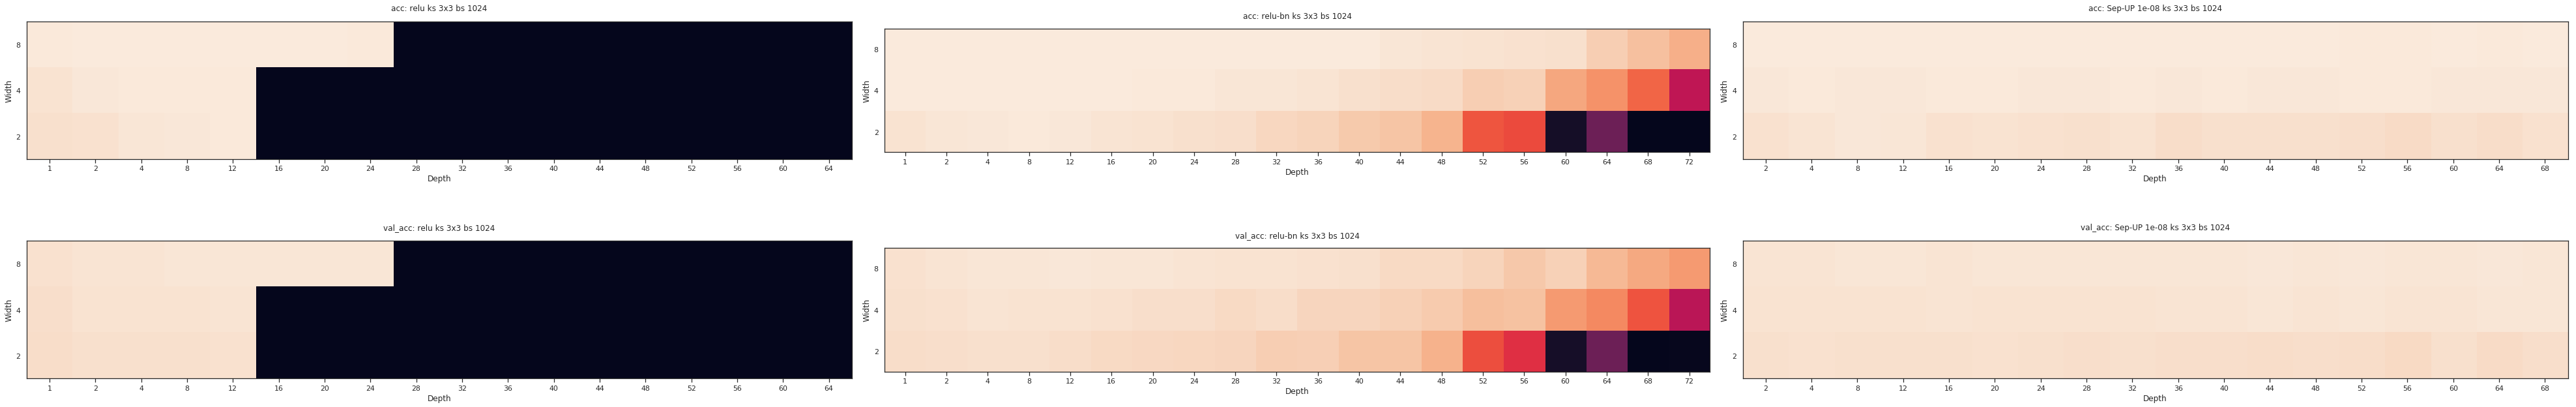

In [8]:
sns.set_style("white")
activations = sorted(results['acc'].keys())

print(activations)
activations = ['relu ks 3x3 bs 1024', 'relu-bn ks 3x3 bs 1024', 'Sep-UP 1e-08 ks 3x3 bs 1024']
# activations = ['relu bs 1024', 'relu-bn bs 1024', 'Sep-UP 0.0001 bs 1024',  'Sep-UP 1e-06 bs 1024', 'Sep-UP 1e-08 bs 1024']
print(activations)

fig, axes = plt.subplots(2,len(activations), figsize=(55, 10))
axes[0,0].set_title('acc')
axes[1,0].set_title('val acc')
axes = iter(axes.flatten())

for metric_name, metric in results.items():    
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
        activation = activation.loc[:8]
        ax = next(axes)
        ax.matshow(activation, origin='lower', vmin=0.1, vmax=1)
        ax.set_title(f'{metric_name}: {activation_name}')
        ax.set_xticks(range(len(activation.columns)))
        ax.set_yticks(range(len(activation.index)))
        ax.set_xticklabels(activation.columns)
        ax.set_yticklabels(activation.index)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Depth')
        ax.set_ylabel('Width')

fig.tight_layout()

In [ ]:
sns.set_style("white")
activations = sorted(results['acc'].keys())
# activations = ['relu',  'relu-bn', 'Sep-UP 0.0001',]
print(activations)

fig, axes = plt.subplots(2,len(activations), figsize=(55, 10))
axes[0,0].set_title('acc')
axes[1,0].set_title('val acc')
axes = iter(axes.flatten())

for metric_name, metric in results.items():    
    print(metric_name)
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
        activation = activation.loc[:25]
        print(activation_name)
        print(activation))

dict_keys(['relu bs 1024', 'Sep-UP 1e-06 bs 1024', 'relu-bn ks 3x3 bs 1024', 'relu-bn bs 1024', 'Sep-UP 0.0001 bs 1024', 'relu ks 3x3 bs 1024', 'Sep-UP 1e-08 ks 3x3 bs 1024', 'Sep-UP 1e-08 bs 1024', 'Sep-UP 1e-08 bs 512', 'Sep-UP 1e-08 bs 128', 'relu-bn bs 64', 'relu-bn bs 128', 'Sep-UP 1e-12 bs 1024', 'relu bs 128', 'Sep-UP 1e-16 bs 1024', 'Sep-UP 0.0001 bs 128', 'Sep-UP 0.0001 bs 85', 'Sep-UP 1.0 bs 1024', 'Sep-UP 1e-08 bs 85', 'Sep-UP 1e-10 bs 1024'])


/home/carles/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


dict_keys(['relu bs 1024', 'Sep-UP 1e-06 bs 1024', 'relu-bn ks 3x3 bs 1024', 'relu-bn bs 1024', 'Sep-UP 0.0001 bs 1024', 'relu ks 3x3 bs 1024', 'Sep-UP 1e-08 ks 3x3 bs 1024', 'Sep-UP 1e-08 bs 1024', 'Sep-UP 1e-08 bs 512', 'Sep-UP 1e-08 bs 128', 'relu-bn bs 64', 'relu-bn bs 128', 'Sep-UP 1e-12 bs 1024', 'relu bs 128', 'Sep-UP 1e-16 bs 1024', 'Sep-UP 0.0001 bs 128', 'Sep-UP 0.0001 bs 85', 'Sep-UP 1.0 bs 1024', 'Sep-UP 1e-08 bs 85', 'Sep-UP 1e-10 bs 1024'])


/home/carles/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


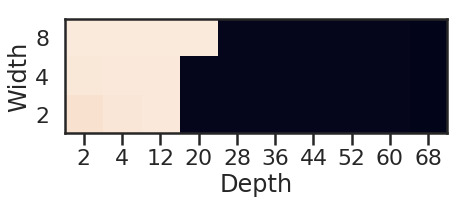

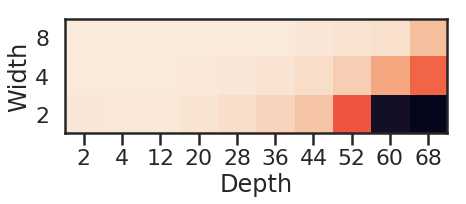

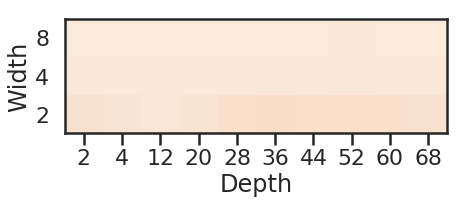

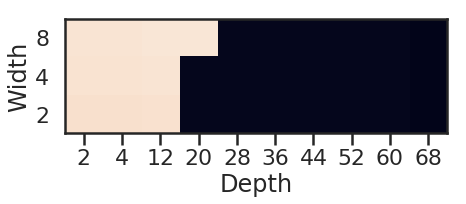

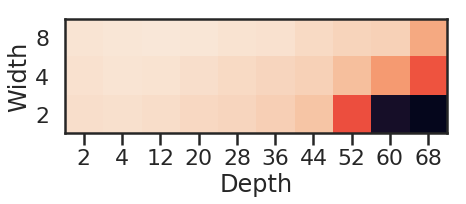

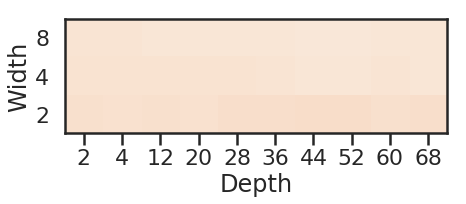

In [54]:
sns.set_style("white")
sns.set_context("poster")
activations = ['relu ks 3x3 bs 1024', 'relu-bn ks 3x3 bs 1024', 'Sep-UP 1e-08 ks 3x3 bs 1024']
output_dir = Path('plots/mnist_grid')
output_dir.mkdir(parents=True, exist_ok=True)
good = [2] + list(range(4,69,8))


for metric_name, metric in results.items():
    print(metric.keys())
#     activations = sorted(list(metric.keys()), reverse=True)
    
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
        activation = activation.loc[:8, good]
        if activation_name == 'relu ks 3x3 bs 1024':
            activation[68] = np.zeros((3,1))
        fig, ax = plt.subplots(1, figsize=(7, 3.5))
        ax.matshow(activation,origin='lower', vmin=0.1, vmax=1)
#         ax.set_title(f'{metric_name}: {activation_name}')
        ax.set_xticks(range(len(activation.columns)))
        ax.set_yticks(range(len(activation.index)))
        ax.set_xticklabels(activation.columns)
        ax.set_yticklabels(activation.index[:8])
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Depth')
        ax.set_ylabel('Width')
        fig.tight_layout()
        fig.savefig(output_dir.joinpath( slugify(f'{metric_name}-{activation_name}') + '.pdf'))